In [ ]:
using Pkg
Pkg.activate("NB04")
Pkg.resolve();

In [ ]:
using LinearAlgebra, Plots, StatsBase
using RDatasets
using Optim

# Regression

Wir laden den Datensatz `cars` aus dem `RDatasets` package

In [40]:
data_cars = dataset("datasets", "cars");

Wir schauen zunächst, welche Variablen in diesem Datensatz erhalten sind

In [41]:
names(data_cars)

2-element Vector{String}:
 "Speed"
 "Dist"

In [42]:
size(data_cars,1)

50

Die Datenpunkte stellen also Geschwindigkeit und zurückgelegte Distanz dar. 

Wir erwarten einen linearen Zusammenhang, also wählen wir das lineare Modell

$$f_\theta(x) =  a x + b$$

mit $\theta =(a,b)\in\mathbb R^2$.

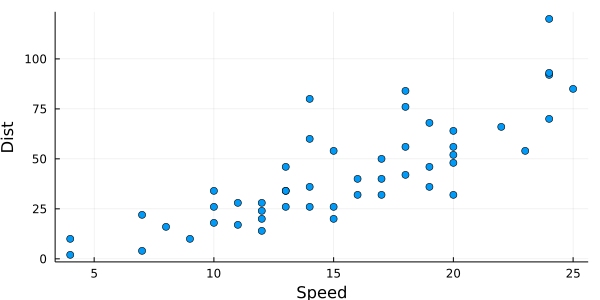

In [43]:
scatter(data_cars[:,"Speed"], data_cars[:,"Dist"], 
            legend=false, 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))

Wir wollen die lineare Abhängigkeit dieser Variablen mittels Regression schätzen.

Beide Variablen sind eindimensional. D.h:

In [44]:
D = 1; N = 1;

## Aufteilen der Daten

Wir teilen die Daten in Trainings- und Testdaten auf.

Die Wahl soll zufällig sein und $75\%$ der Daten sollen Trainingsdaten sein.

In [45]:
k = size(data_cars, 1)
n = round(Int, k * 0.75)

38

Die Trainingsdaten speichern wir in den Vektoren `X` und `Y`.

In [46]:
i_training = sample(1:k, n, replace = false)
X = data_cars[i_training,"Speed"]
Y = data_cars[i_training,"Dist"];

Die Testdaten speichern wir in den Vektoren `X_test` und `Y_test`.

In [47]:
i_test = setdiff(1:k, i_training)
X_test = data_cars[i_test,"Speed"]
Y_test = data_cars[i_test,"Dist"];

## Definition des Modells

Wir definieren nun das deterministische lineare Modell $f:\mathbb R^D \to \mathbb R^N$:

In [48]:
f(x::Number, θ) = θ[2] * x + θ[1];

Da $N=1$ können wir für `x` den Typ `Number` angeben. 

Es wird später außerdem hilfreich sein, per Multiple-Dispatch die Definition von `f` auf Vektoren zu erweitern.

In [49]:
f(X::Vector, θ) = [f(x, θ) for x in X]

f (generic function with 2 methods)

Wir definieren weiterhin das statistische Modell für die Varianz $\sigma^2=10$.

In [50]:
σ² = 10
s = sqrt(σ²)
Φ(x::Number, θ) = s * randn() + f(x, θ)
Φ(X::Vector, θ) = [Φ(x, θ) for x in X];

Wir definieren außerdem die Feature Matrix.

In [51]:
Ω = [ones(n) X];

---
## Training

Jetzt trainieren wir unser Modell mit verschiedenen Methoden. 

#### Empirical Risk Minimization

Bei ERM ist der Parameter durch $\theta = \Omega^\dagger Y$ gegeben.

Wir berechnen diesen Parameter wie folgt:

In [52]:
θ_ERM = Ω \ Y

2-element Vector{Float64}:
 -22.0448343079922
   4.2592592592592595

ERM hat die folgenden Parameter für $f_\theta(x)=ax+b$ geschätzt.

In [53]:
println("a = $(θ_ERM[2]), b = $(θ_ERM[1])")

a = 4.2592592592592595, b = -22.0448343079922


Wir visualieren die geschätzte Funktion zusammen mit den Trainingsdaten.

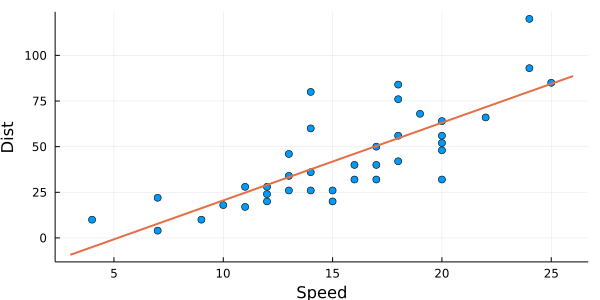

In [54]:
p = collect((minimum(X)-1):0.5:(maximum(X)+1))

scatter(X,Y, legend=false, 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
plot!(p, f(p, θ_ERM), lw = 2)

### Ridge Regression

Der Ridge-Regression Schätzer mit Parameter $\lambda$ wird wie folgt berechnet.

In [55]:
θ_T(λ) = (Ω' * Ω + (n*λ) .* diagm(ones(D+1))) \ (Ω' * Y)

θ_T (generic function with 1 method)

Wir plotten den RR-Schätzer für verschiedene Werte von $\lambda$

┌ Info: Saved animation to 
│   fn = /Users/pb/ridge_regression.gif
└ @ Plots /Users/pb/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/Users/pb/ridge_regression.gif")
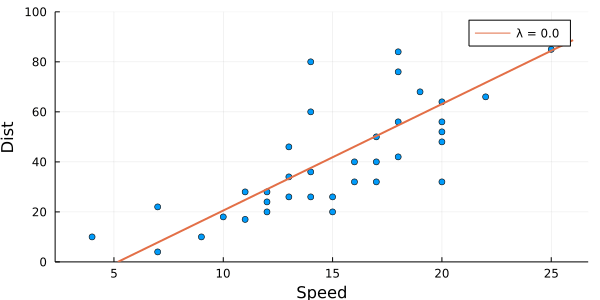

In [56]:
anim = @animate for λ in 0:0.02:0.25
    scatter(X,Y, label=false, 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
    plot!(p, f(p, θ_T(λ)), lw = 2, label = "λ = $λ")
    ylims!(0,100)
end
gif(anim, "/Users/pb/ridge_regression.gif", fps = 3)

Der Animation nach zu urteilen scheint $\lambda=0.2$ eine gute Wahl zu sein.

In [57]:
θ_RR = θ_T(0.2);

RR hat die folgenden Parameter für $f_\theta(x)=ax+b$ geschätzt.

In [58]:
println("a = $(θ_RR[2]), b = $(θ_RR[1])")

a = 3.3466180982126152, b = -6.5824135931410135


### Maximum Likelihood und Maximum a-Posteriori Estimation

Der Parameter für ML ist durch `θ_ERM` bestimmt

Der Parameter für MAP ist durch `θ_T(λ)` für $\lambda = \sigma^2/n$ bestimmt.

In [59]:
θ_ML = θ_ERM
θ_MAP = θ_T(σ²/n);

Jetzt können wir diese Parameter in das statistische Modell einsetzen und von diesem samplen. 

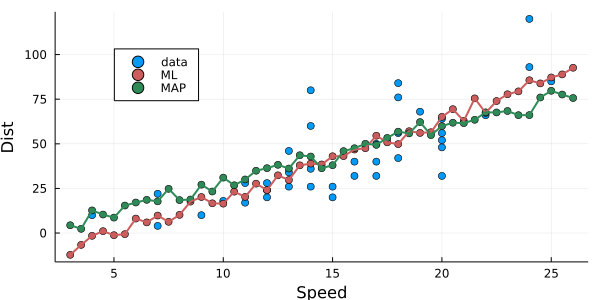

In [63]:
a1 = Φ(p, θ_ML)
a2 =  Φ(p, θ_MAP)
scatter(X,Y, label = "data", legend = (0.2,0.8),
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
scatter!(p, a1, lw = 2, c = :indianred, label ="ML")
scatter!(p, a2, lw = 2, c = :seagreen, label = "MAP")
plot!(p, a1, lw = 2, c = :indianred, label = false)
plot!(p, a2, lw = 2, c = :seagreen, label = false)

### Neural Network

Zuletzt wollen wir die Abhängigkeit von `Dist` und `Speed` durch ein neuronales Netz bestimmen.

Wir verwenden die ReLu Activation Function.

In [149]:
σ(z) = max(0,z);

Wir definieren das Modell durch ein neuronales Netz von Tiefe 2 und mit inneren Layer, der durch lineare Funktionen $\mathbb R^1\to \mathbb R^2$ und $\mathbb R^2\to \mathbb R^1$ gegeben ist. 

Dies ist ein sehr simples neuronales Netz, eignet sich daher aber gut um die Funktionsweise zu veranschaulichen.

In [150]:
function f_NN(x::Number, θ)
    A, b = reshape(θ[1:2], 2, 1), θ[3:4]
    y = σ.(A * x + b)
    
    A, b = reshape(θ[5:6], 1, 2), θ[7:7]
    z = σ.(A * y + b)
    
    z[1]
end
f_NN(X::Vector, θ) = [f_NN(x, θ) for x in X];

Da wir für das neuronale Netz keine geschlossene Form für den ERM-Schätzer `θ_ERM` haben, müssen wir `θ_ERM` durch Optimierungsmethoden bestimmen.

Wir werden die Blackbox `optimize` Funktion aus dem Package `Optim.jl`.

In [151]:
R_NN(θ, X, Y) = mean((f_NN(X, θ) - Y).^2)
o = optimize(θ -> R_NN(θ, X, Y), rand(7))
θ_NN = Optim.minimizer(o);

Das neuronale Netz hat nun eine Funktion geschätzt, die wir wieder zusammen mit den Trainingsdaten visualisieren.

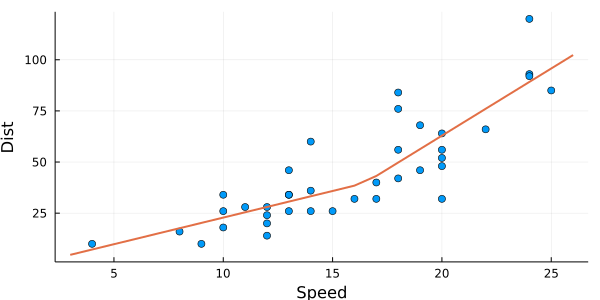

In [152]:
scatter(X,Y, legend=false, 
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
plot!(p, f_NN(p, θ_NN), lw = 2)

## Model Selection

Zuletzt wollen wir beurteilen, welches Modell am besten geeignet ist, um die Daten zu beschreiben. Dazu evaluieren wir die Schätzer auf den Testdaten.

Zuerst plotten wir alle geschätzten Funktionen zusammen mit den Testdaten.

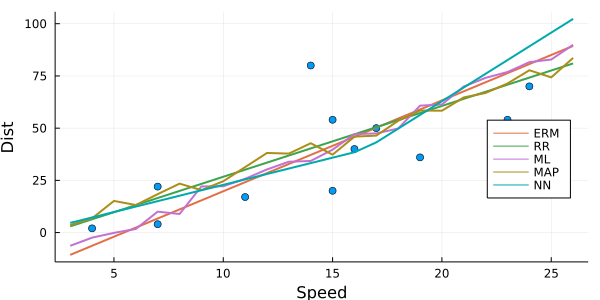

In [153]:
scatter(X_test,Y_test, legend=1,
            label = false,
            xlabel = "Speed",
            ylabel = "Dist",
            size = (600,300))
plot!(p, f(p, θ_ERM), lw = 2, label = "ERM")
plot!(p, f(p, θ_RR), lw = 2, label = "RR")
plot!(p, Φ(p, θ_ML), lw = 2, label = "ML")
plot!(p, Φ(p, θ_MAP), lw = 2, label = "MAP")
plot!(p, f_NN(p, θ_NN), lw = 2, label = "NN")

Um zu beurteilen, welches Modell wie gut funktioniert, definieren wir das empirische Risiko.

In [154]:
R(θ, f, X, Y) = mean((f(X, θ) - Y).^2)

R (generic function with 1 method)

Das empirische Risiko für Trainings- und Testdaten im deterministischen linearen Modell ist wie folgt.

In [155]:
r = [(R(θ, f, X_test, Y_test), R(θ, f, X, Y)) for θ in [θ_ERM, θ_RR]]   
println("Risiko Testdaten ERM: $(r[1][1])\n")
println("Risiko Trainingsdaten ERM: $(r[1][2])\n")
println("ERM Risikoverhältnis: $(r[1][1]/r[1][2])\n")
println("Risiko Testdaten RR: $(r[2][1])\n")
println("Risiko Trainingsdaten RR: $(r[2][2])\n")
println("RR Risikoverhältnis: $(r[2][1]/r[2][2])\n")

Risiko Testdaten ERM: 332.30640034322425

Risiko Trainingsdaten ERM: 200.26963132150703

ERM Risikoverhältnis: 1.6592950121815986

Risiko Testdaten RR: 285.3725545807998

Risiko Trainingsdaten RR: 224.73914069625516

RR Risikoverhältnis: 1.2697946325535405



Für das neuronale Netz ergeben sich folgende Werte.

In [156]:
r = (R(θ_NN, f_NN, X_test, Y_test), R(θ_NN, f_NN, X, Y))
println("Risiko Testdaten NN: $(r[1])\n")
println("Risiko Trainingsdaten NN: $(r[2])\n")
println("NN Risikoverhältnis: $(r[1]/r[2])\n")

Risiko Testdaten NN: 390.2649963109238

Risiko Trainingsdaten NN: 174.3110442832809

NN Risikoverhältnis: 2.238899995783894



---
# Regularisierung

In obigem Beispiel sehen wir keinen großen Unterschied zwischen ERM und RR. 

Es folgt ein Beispiel, für das Regularisierung wichtig ist.

Dazu generieren wir $n=20$ synthetische Daten von einem kubischen Polynom plus Noise:

In [32]:
q = (x -> 1 + 4*x + 2*x^2 - 0.5*x^3)

n = 20
P = 4
X = 10 .* (rand(n) .- 0.5); # randn sampled von Unif([-5,5])
Y = map(q, X) + 5 .* randn(n);

Wir plotten die Daten:

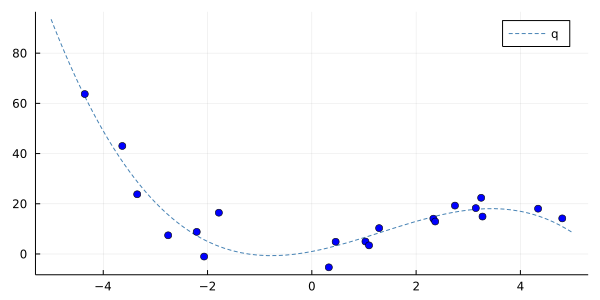

In [33]:
plot(q, label = "q", size = (600,300), linestyle = :dash, color = :steelblue)
scatter!(X,Y, label=false, color = :blue)

Wir berechnen Feature Matrix und RR Parameter.

In [34]:
Ω = hcat([X.^i for i in 0:P-1]...)
θ_T(λ) = (Ω' * Ω + (n*λ) .* diagm(ones(P))) \ (Ω' * Y)

θ_T (generic function with 1 method)

Für jeden Wert von $\lambda$ erhalten wir dann ein Polynom wie folgt:'

In [35]:
Q(λ) = (x -> sum(θ * x^(i-1) for (i,θ) in enumerate(θ_T(λ))))

Q (generic function with 1 method)

Die folgende Animation zeigt, dass Regularisierung ($\lambda >0$) ein besseres Ergebnis als keine Regularisierung ($\lambda =0$) erzielt. 

┌ Info: Saved animation to 
│   fn = /Users/pb/ridge_regression.gif
└ @ Plots /Users/pb/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/Users/pb/ridge_regression.gif")
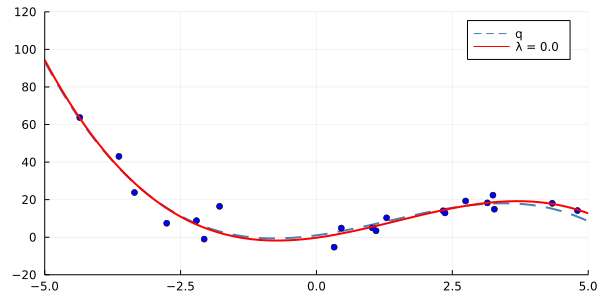

In [38]:
anim = @animate for λ in 0:10
    plot(q, label = "q", size = (600,300), linestyle = :dash, lw = 2,
        color = :steelblue, 
        xlims = (-5,5),
        ylims = (-20, 120))
    scatter!(X,Y, label=false, color = :blue)
    plot!(Q(λ/n), label = "λ = $(λ/n)", color = :red, lw = 2)
end
gif(anim, "/Users/pb/ridge_regression.gif", fps = 2)